# Download Air Traffic Data and Import Basic Pkgs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ipdb

# Load Data

In [3]:
sl_data = pd.read_csv('./data/Smart Location Data Export.csv')

In [4]:
sl_data.head(2)

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,...,Com_VMT_Per_Worker,VMT_per_worker,VMT_tot_min,VMT_tot_max,VMT_tot_avg,GHG_per_worker,Annual_GHG,SLC_score,Shape_Length,Shape_Area
0,1,481130078254,481130078254,48,113,7825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,21.688738,27.496405,11.442995,82.636303,25.659327,24.499297,6369.817221,77.450956,3110.36082,297836.0831
1,2,481130078252,481130078252,48,113,7825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,21.379832,26.465754,11.442995,82.636303,25.659327,23.580987,6131.056669,78.898635,3519.46911,484945.1466


In [3]:
# generate an OD matrix from cumulative trip record
# completed by code "OD_batch.py"

In [4]:
year = 2019
quarter = 4

OD = pd.read_csv('./outputs/%i0%i_OD.csv'%(year, quarter), index_col=0)


In [9]:
np.linalg.matrix_rank(OD.to_numpy())

433

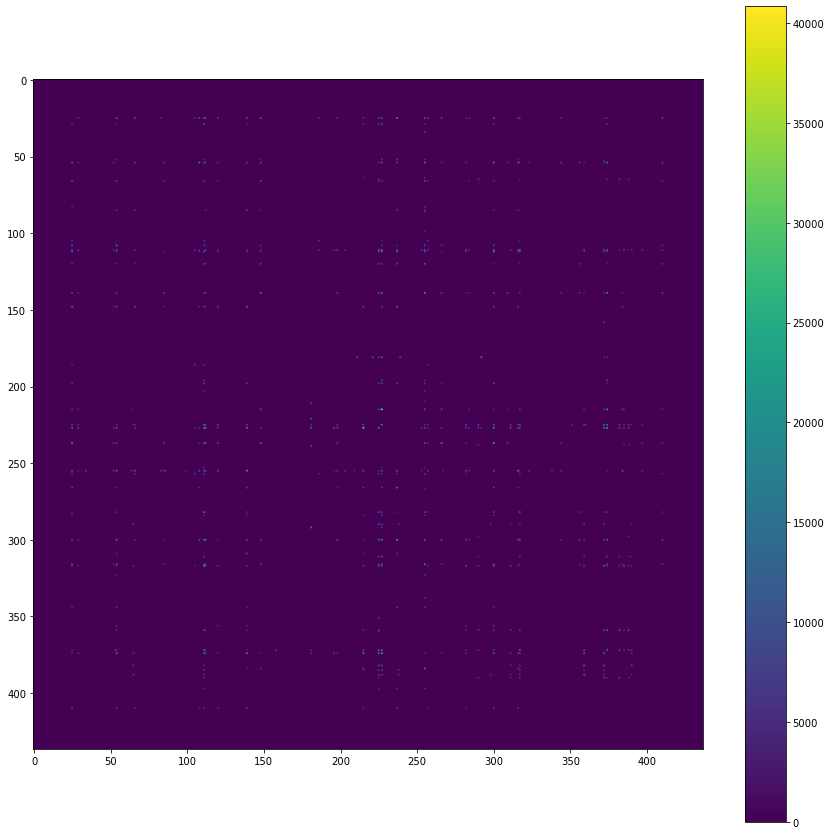

In [48]:
OD_np = OD.to_numpy()
plt.figure(figsize=[15, 15])
plt.imshow(OD_np)
plt.colorbar()

In [30]:
OD_np[OD_np<5000] = 0
np.linalg.matrix_rank(OD_np)

54

In [32]:
w, v = np.linalg.eig(OD_np)

In [37]:
(OD_np==0).sum()

190271